In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import requests
import pickle
import json
import datetime
import random

seed=117
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


## Protein Disorder Prediction

### Data set-up

Import drive, so that preprocessed data can be used in Notebook.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Quick access to preprocessed data, instead of downloading it each time Notebook is opened.

In [3]:

def read_sequences():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/sequence_data.json', 'r') as infile:
    return json.load(infile)

def read_cleaned_pandas_data():
  return pd.read_json('/content/drive/My Drive/Colab Notebooks/diss_files/idr_pandas_table.json')

def read_onehot():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/onehot_data.json', 'r') as infile:
    onehot_map = json.load(infile)
    onehot_map.update((acc, np.array(onehot)) for acc, onehot in onehot_map.items())
    return onehot_map

def read_pssms():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/pssm_data.json', 'r') as infile:
    pssm_map = json.load(infile)
    pssm_map.update((acc, np.array(pssm)) for acc, pssm in pssm_map.items())
    return pssm_map

def read_homo_solution():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/homo_solution.json', 'r') as infile:
    return json.load(infile)

# Protein sequences
protein_sequences_n_ids = read_sequences()
# IDRs
pandas_data_IDRs = read_cleaned_pandas_data()
# One-hot features
onehot_map = read_onehot()
# PSSM features
pssm_map = read_pssms()
# Randomly sampled dataset split from pre-processing.
# Data leakage prevention included.
non_leaking_dataset_split = read_homo_solution()

### Dataset class for our data. 
- Takes in pandas data (usually full TSV).
- The amino acid vectorising map.
- A dictionary mapping protein accession numbers to their sequence (generated from preprocessing).

In [4]:
class DisProtDataset(Dataset):
    def __init__(self, pandas_table, vector_map, protein_sequences, ids, transform=None):
        self.disorder_prot = pandas_table
        self.vectorised_seqs = vector_map
        self.sequences = protein_sequences
        self.ids = ids
        self.tranform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.ids[idx]
        # Each row must have a unique accession number, hence we can 0 index this list
        dataframe_idx = self.disorder_prot.index[self.disorder_prot['acc'] == acc].tolist()[0]
        idrs = self.disorder_prot['disordered_regions'].loc[dataframe_idx]
        
        # Get vectorised sequence
        vectorised_protein_sequence = self.vectorised_seqs.get(acc)

        # Get protein sequence
        protein_sequence = self.sequences.get(acc)
        
        # Create order/disorder label
        disorder_label = np.zeros(len(protein_sequence))
        for (start, end) in idrs:
          disorder_label[start-1:end] = 1

        get_dict = {'acc': acc, 'seq': vectorised_protein_sequence, 'label': disorder_label}
        return get_dict

Separate train/validation/test datasets. Currently using a 60/20/20 in place split from generated pandas data.

In [5]:
train_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])
train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=0)

train_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])
train_pssm_loader = DataLoader(train_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)
validation_pssm_loader = DataLoader(validation_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)
test_pssm_loader = DataLoader(test_pssm_dataset, batch_size=1,
                        shuffle=False, num_workers=0)

### Loading PyTorch NN models.

In [6]:
class FCN_1D_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(20, 10, 21, padding=10)
        self.conv2 = nn.Conv1d(10, 10, 21, padding=10)
        self.conv3 = nn.Conv1d(10, 10, 21, padding=10)
        self.do1 = nn.Dropout(0.5)
        self.conv4 = nn.Conv1d(10, 10, 21, padding=10)
        self.do2 = nn.Dropout(0.5)
        self.conv5 = nn.Conv1d(10, 1, 21, padding=10)
        self.do3 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.do1(F.relu(self.conv3(x)))
        x = self.do2(F.relu(self.conv4(x)))
        x = self.do3(self.conv5(x))
        # Removal of final activation function due to BCE With Logits Loss being used
        #x = torch.sigmoid(self.conv5(x))
        return x


class FCN_2D_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, (20, 21), padding=(0,10))
        self.conv2 = nn.Conv2d(1, 1, (1, 21), padding=(0,10))
        self.conv3 = nn.Conv2d(1, 1, (1, 21), padding=(0,10))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = torch.sigmoid(self.conv3(x))
        x = self.conv3(x)
        return x


class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 20 inputs - for each amino acid
        self.input_dim = 20
        self.hidden_dim = 32
        self.num_layers = 2
        self.rnn1 = nn.LSTM(input_size=20, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(self.hidden_dim*2, 8)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(8, 1)
        #self.sig1 = nn.Sigmoid()

    def init_hidden(self, batch_size):
        # Initialise hidden state
        return (torch.zeros(self.num_layers*2, batch_size, self.hidden_dim), 
                torch.zeros(self.num_layers*2, batch_size, self.hidden_dim))

    def forward(self, x):
      batch_size = x.size(0)
      h    = self.init_hidden(batch_size)

      y, h = self.rnn1(x,h)
      y = self.relu1(self.linear(y))
      y = self.linear2(y)
      
      return y, h

### Get all trained models

In [20]:
# Reads trained model from storage
def read_model(model_class, model_name):
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/'+model_name

  loaded_model = model_class
  loaded_model.load_state_dict(torch.load(PATH))
  return loaded_model

cnn_1d_one_hot = read_model(FCN_1D_Net(), '1hot_1D_cnn_net.pth')
cnn_1d_pssm = read_model(FCN_1D_Net(), 'pssm_1D_cnn_net.pth')
cnn_2d_one_hot = read_model(FCN_2D_Net(), '1hot_2D_cnn_net.pth')
cnn_2d_pssm = read_model(FCN_2D_Net(), 'pssm_2D_cnn_net.pth')
rnn_one_hot = read_model(RNN_Net(), '1hot_rnn_net.pth')
rnn_pssm = read_model(RNN_Net(), 'pssm_rnn_net.pth')

### Matthews correlation coefficient

MCC = $\frac{(TP * TN) - (FP * FN)}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}}$

Where the variables are:
- TP - when a disordered protein is classified as disordered. A 1 is said to be a 1.
- FP - when an ordered protein is classified as disordered.   A 0 is said to be a 1.
- TN - when an ordered protein is classified as ordered.      A 0 is said to be a 0.
- FN - when an disordered protein is classified as ordered.   A 1 is said to be a 0.

- We set our threshold as 0.5 in pred_round.
- Class correctness efficiently gets our TP, TN, FP and FN labels.

In [8]:
# Turns the prediction to a list of ordered/disordered (0/1) predictions
def pred_round(predicted_label):
  predicted_label[predicted_label>=0.5] = 1
  predicted_label[predicted_label<0.5] = 0
  return predicted_label

def class_correctness(predicted_label, true_label):
  # Calculating TN value
  # Sum as True values take on the value of 1
  TN = (true_label[predicted_label == 0] == 0).sum()
  # Calculating FN
  FN = (true_label[predicted_label == 0] == 1).sum()
  # Calculating TP
  TP = (true_label[predicted_label == 1] == 1).sum()
  FP = (true_label[predicted_label == 1] == 0).sum()
  #print("TP: ",TP,"\nFP: ",FP,"\nTN: ",TN,"\nFN: ",FN)
  return {'TN':TN, 'FN':FN, 'TP':TP, 'FP':FP}

def calc_MCC(TP, TN, FP, FN):
  num = (TP * TN) - (FP * FN)
  den = torch.sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) )
  if den == 0:
    return 0
  MCC = num / den
  #print("MCC: ", MCC)
  return MCC

Dataset MCC. This was our main evaluation metric. This is built into the lower functions.

In [9]:
def calculate_dataset_mcc(name, dataset, model):
  TP = TN = FP = FN = 0

  mcc_sum = 0

  for seq in dataset:
    input_seq = seq.get('seq')
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)

    with torch.no_grad():
      predicted_label = model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    correct_dict = class_correctness(pred_lab, true_label)
    TP += (correct_dict.get('TP'))
    TN += (correct_dict.get('TN'))
    FP += (correct_dict.get('FP'))
    FN += (correct_dict.get('FN'))

    mcc_sum += calc_MCC(correct_dict.get('TP'), correct_dict.get('TN'), correct_dict.get('FP'), correct_dict.get('FN'))


  # Using all labels vs using average sequence mcc score over dataset
  mcc_raw = calc_MCC(torch.Tensor([TP]), torch.Tensor([TN]), torch.Tensor([FP]), torch.Tensor([FN]))
  print(name+" MCC score: ", mcc_raw)

  print("MCC average: ", mcc_sum / len(dataset))

  data = [[TN, FP],
        [FN, TP]]
  labels = ["Ordered", "Disordered"]
  #plot_confusion_matrix(data, labels, "confusion_matrix.png")

In [10]:
#calculate_dataset_mcc("Test", test_loader, cnn_1d_one_hot)

Pre-made confusion matrix

In [11]:
#https://onestopdataanalysis.com/confusion-matrix-python/

import seaborn
import matplotlib.pyplot as plt
 
 
def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=1.4)
    #https://stackoverflow.com/questions/60240694/suppress-scientific-notation-in-sklearn-metrics-plot-confusion-matrix
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt='g')
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

    plt.show()
    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    #plt.close()


### Evaluation assessments

Our other evaluation metrics.

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234


Accuracy = $\frac{Number of Correct predictions}{Total number of predictions made}$ = $\frac{TP+TN}{TP+TN+FP+FN}$

Precision = $\frac{TP}{TP+FP}$

Recall = $\frac{TP}{TP+FN}$

Specificity = $\frac{TN}{TN+FP}$

F1-score = $\frac{2 * precision * recall}{precision+recall}$

In [22]:
def calculate_dataset_metrics(name, dataset, model, conf_mat=True, rnn=False):
  TP = TN = FP = FN = 0

  model.eval()
  for seq in dataset:
    input_seq = seq.get('seq')
    if rnn:
      input_seq = torch.einsum('ijk->ikj', input_seq)
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)

    with torch.no_grad():
      if rnn:
        predicted_label, _ = model(input_seq)
      else:
        predicted_label = model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    correct_dict = class_correctness(pred_lab, true_label)
    TP += (correct_dict.get('TP'))
    TN += (correct_dict.get('TN'))
    FP += (correct_dict.get('FP'))
    FN += (correct_dict.get('FN'))

  data = [[TN, FP],
        [FN, TP]]
  labels = ["Ordered", "Disordered"]
  if conf_mat == True:
    plot_confusion_matrix(data, labels, "confusion_matrix.png")


  accuracy = (TP+TN) / (TP+TN+FP+FN)
  precision = TP / (TP+FP)
  recall = TP / (TP+FN)
  specificity = TN / (TN+FP)
  f1score = (2*precision*recall) / (precision + recall)

  mcc_raw = calc_MCC(TP, TN, FP, FN)

  tp = torch.Tensor([TP])
  tn = torch.Tensor([TN])
  fp = torch.Tensor([FP])
  fn = torch.Tensor([FN])
  n = (tp * tn) - (fp * fn)
  d = torch.sqrt( (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) )
  if d == 0:
    mcc = 0
  else:
    mcc = n / d

  print("Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.")
  print("Accuracy:\t ", accuracy)
  print("Precision:\t ", precision)
  print("Recall:\t\t ", recall)
  print("Specificity:\t ", specificity)
  print("F1 score:\t ", f1score)
  print("MCC: \t\t", mcc)

  #calculate_dataset_mcc("Test", dataset, model)
  


In [23]:
def calc_acc(tp, tn, fp, fn):
  if (tp+tn+fp+fn) == 0:
    return 0
  else:
    return (tp+tn) / (tp+tn+fp+fn)

def calc_prec(tp, tn, fp, fn):
  if (tp+fp) == 0:
    return 0
  else:
    return tp / (tp+fp)

def calc_rec(tp, tn, fp, fn):
  if (tp+fn) == 0:
    return 0
  else:
    return tp / (tp+fn)

def calc_spec(tp, tn, fp, fn):
  if (tn+fp) == 0:
    return 0
  else:
    return tn / (tn+fp)

def calc_f1(precision, recall):
  if (precision + recall) == 0:
    return 0
  else:
    return (2*precision*recall) / (precision + recall)


def evaluation_metrics_averaged(name, dataset, model, rnn=False):
  TP = TN = FP = FN = 0

  accuracy_sum = 0
  precision_sum = 0
  recall_sum = 0
  specificity_sum = 0
  f1score_sum = 0
  mcc_sum = 0

  for seq in dataset:
    input_seq = seq.get('seq')
    if rnn:
      input_seq = torch.einsum('ijk->ikj', input_seq)
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)

    with torch.no_grad():
      if rnn:
        predicted_label, _ = model(input_seq)
      else:
        predicted_label = model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    correct_dict = class_correctness(pred_lab, true_label)
    TP += (correct_dict.get('TP'))
    TN += (correct_dict.get('TN'))
    FP += (correct_dict.get('FP'))
    FN += (correct_dict.get('FN'))

    tp = (correct_dict.get('TP'))
    tn = (correct_dict.get('TN'))
    fp = (correct_dict.get('FP'))
    fn = (correct_dict.get('FN'))
    accuracy_sum += calc_acc(tp,tn,fp,fn)
    precision = calc_prec(tp,tn,fp,fn)
    recall = calc_rec(tp,tn,fp,fn)
    precision_sum += precision
    recall_sum += recall
    specificity_sum += calc_spec(tp,tn,fp,fn)
    f1score_sum += calc_f1(precision, recall)
    mcc_sum += calc_MCC(tp, tn, fp, fn)


  print("\nConsidering our metrics as an average of these metrics per sequence over the entire dataset.")
  print("Accuracy averaged over sequences:\t ", accuracy_sum / len(dataset))
  print("Precision averaged over sequences:\t ", precision_sum / len(dataset))
  print("Recall averaged over sequences:\t\t ", recall_sum / len(dataset))
  print("Specificity averaged over sequences:\t ", specificity_sum / len(dataset))
  print("F1-score averaged over sequences:\t ", f1score_sum / len(dataset))
  print("MCC averaged over sequences:\t\t ", mcc_sum / len(dataset))

  accuracy = accuracy_sum / len(dataset)
  precision = precision_sum / len(dataset)
  recall = recall_sum / len(dataset)
  specificity = specificity_sum / len(dataset)
  f1_score = f1score_sum / len(dataset)
  mcc = mcc_sum / len(dataset)

  data = [[TN, FP],
        [FN, TP]]
  labels = ["Ordered", "Disordered"]
  #plot_confusion_matrix(data, labels, "confusion_matrix.png")

  #return accuracy, precision, recall, specifici

#### 1D CNN

One-hot

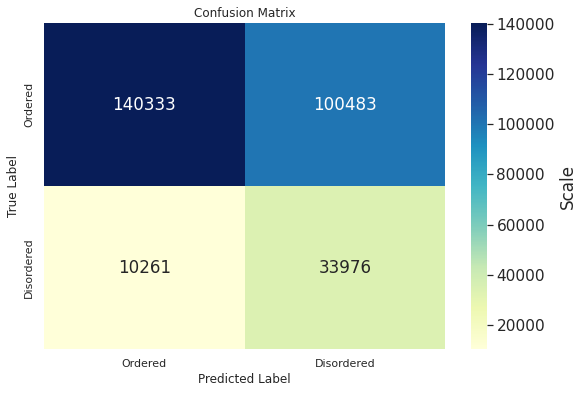

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.6115)
Precision:	  tensor(0.2527)
Recall:		  tensor(0.7680)
Specificity:	  tensor(0.5827)
F1 score:	  tensor(0.3803)
MCC: 		 tensor([0.2544])

Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.6007)
Precision averaged over sequences:	  tensor(0.3129)
Recall averaged over sequences:		  tensor(0.7567)
Specificity averaged over sequences:	  tensor(0.4932)
F1-score averaged over sequences:	  tensor(0.3788)
MCC averaged over sequences:		  tensor(0.1882)


In [24]:
calculate_dataset_metrics("Test", test_loader, cnn_1d_one_hot)
evaluation_metrics_averaged("Test", test_loader, cnn_1d_one_hot)

PSSM

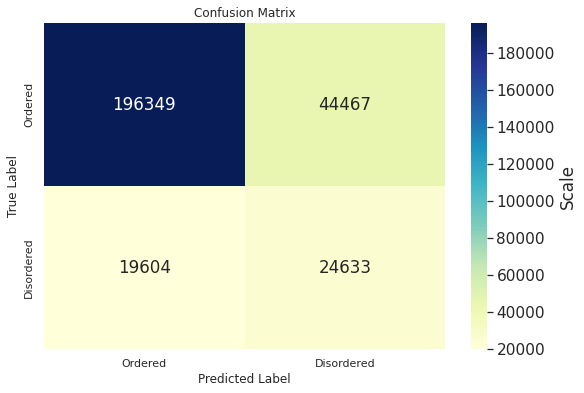

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.7752)
Precision:	  tensor(0.3565)
Recall:		  tensor(0.5568)
Specificity:	  tensor(0.8153)
F1 score:	  tensor(0.4347)
MCC: 		 tensor([0.3145])

Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.7401)
Precision averaged over sequences:	  tensor(0.3980)
Recall averaged over sequences:		  tensor(0.5077)
Specificity averaged over sequences:	  tensor(0.7333)
F1-score averaged over sequences:	  tensor(0.3793)
MCC averaged over sequences:		  tensor(0.2338)


In [25]:
calculate_dataset_metrics("Test", test_pssm_loader, cnn_1d_pssm)
evaluation_metrics_averaged("Test", test_pssm_loader, cnn_1d_pssm)

#### 2D CNN

One-hot

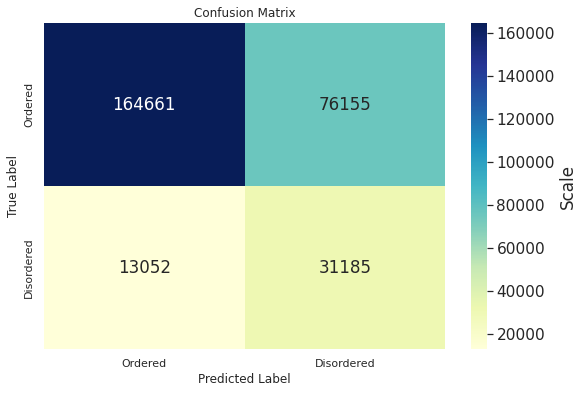

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.6871)
Precision:	  tensor(0.2905)
Recall:		  tensor(0.7050)
Specificity:	  tensor(0.6838)
F1 score:	  tensor(0.4115)
MCC: 		 tensor([0.2905])

Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.6730)
Precision averaged over sequences:	  tensor(0.3653)
Recall averaged over sequences:		  tensor(0.7028)
Specificity averaged over sequences:	  tensor(0.6109)
F1-score averaged over sequences:	  tensor(0.4050)
MCC averaged over sequences:		  tensor(0.2449)


In [26]:
calculate_dataset_metrics("Test", test_loader, cnn_2d_one_hot)
evaluation_metrics_averaged("Test", test_loader, cnn_2d_one_hot)

PSSM

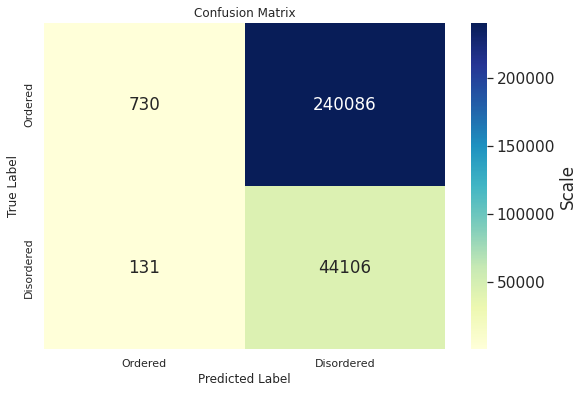

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.1573)
Precision:	  tensor(0.1552)
Recall:		  tensor(0.9970)
Specificity:	  tensor(0.0030)
F1 score:	  tensor(0.2686)
MCC: 		 tensor([0.0005])

Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.2440)
Precision averaged over sequences:	  tensor(0.2417)
Recall averaged over sequences:		  tensor(0.9967)
Specificity averaged over sequences:	  tensor(0.0082)
F1-score averaged over sequences:	  tensor(0.3284)
MCC averaged over sequences:		  tensor(0.0076)


In [27]:
calculate_dataset_metrics("Test", test_pssm_loader, cnn_2d_one_hot)
evaluation_metrics_averaged("Test", test_pssm_loader, cnn_2d_one_hot)

#### LSTM

One-hot

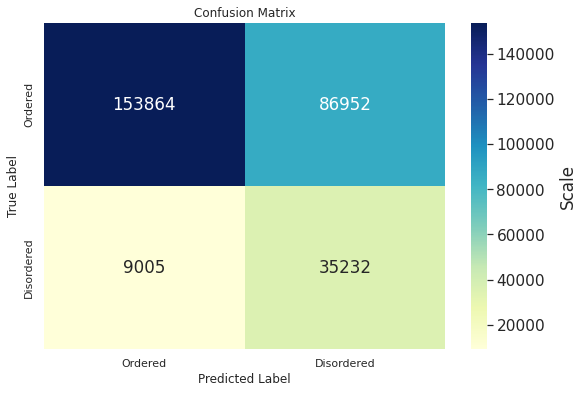

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.6634)
Precision:	  tensor(0.2884)
Recall:		  tensor(0.7964)
Specificity:	  tensor(0.6389)
F1 score:	  tensor(0.4234)
MCC: 		 tensor([0.3185])

Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.6072)
Precision averaged over sequences:	  tensor(0.3278)
Recall averaged over sequences:		  tensor(0.8145)
Specificity averaged over sequences:	  tensor(0.4704)
F1-score averaged over sequences:	  tensor(0.4056)
MCC averaged over sequences:		  tensor(0.2076)


In [30]:
calculate_dataset_metrics("Test", test_loader, rnn_one_hot, rnn=True)
evaluation_metrics_averaged("Test", test_loader, rnn_one_hot, rnn=True)

PSSM

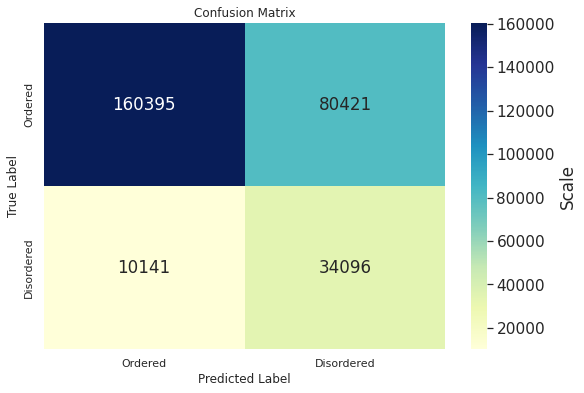

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.6823)
Precision:	  tensor(0.2977)
Recall:		  tensor(0.7708)
Specificity:	  tensor(0.6660)
F1 score:	  tensor(0.4295)
MCC: 		 tensor([0.3226])

Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.6549)
Precision averaged over sequences:	  tensor(0.3516)
Recall averaged over sequences:		  tensor(0.7707)
Specificity averaged over sequences:	  tensor(0.5537)
F1-score averaged over sequences:	  tensor(0.4192)
MCC averaged over sequences:		  tensor(0.2443)


In [31]:
calculate_dataset_metrics("Test", test_pssm_loader, rnn_pssm, rnn=True)
evaluation_metrics_averaged("Test", test_pssm_loader, rnn_pssm, rnn=True)